In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import *

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
im_width = 101
im_height = 101
border = 5
im_chan = 1
n_features = 1 
path_train = 'data/train/'
path_test = 'data/test/'

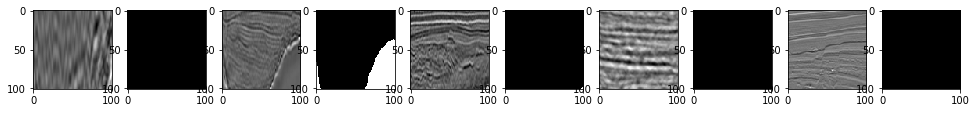

In [3]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('data/train/images/' + img_name + '.png')
    img_mask = load_img('data/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [4]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [5]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (101, 101 , 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (101, 101, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


A Jupyter Widget


Done!


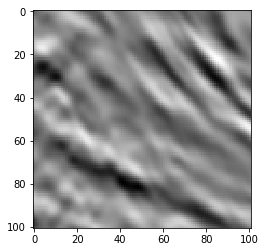

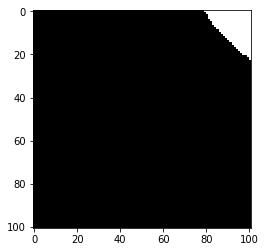

In [6]:
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [7]:
X_train , X_val , Y_train , Y_val = train_test_split(X_train , Y_train , train_size = 0.9 , random_state = 2019)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
image_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

mask_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

val_image_generator = ImageDataGenerator(
)
val_mask_generator = ImageDataGenerator(
)

train_img_gen = image_generator.flow(X_train , seed = 2018 , batch_size = 64)
train_mask_gen = mask_generator.flow(Y_train , seed = 2018 , batch_size = 64)

val_img_gen = val_image_generator.flow(X_val , seed = 2018 , batch_size = 64)
val_mask_gen = val_mask_generator.flow(Y_val , seed = 2018 , batch_size = 64)

In [9]:
train_gen = zip(train_img_gen , train_mask_gen)
val_gen = zip(val_img_gen , val_mask_gen)

In [10]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [11]:
def downsample(inputs):
    avg_pool = AveragePooling2D(pool_size = (2 , 2) , strides = 2 , padding = 'same')(inputs)
    return avg_pool

In [12]:
def convlayer(inputs , filters , kernel_size , strides , activation = 'relu'):
    if(kernel_size == 3):
        X = Conv2D(filters , kernel_size = kernel_size , strides = strides , padding = 'same')(inputs)
    else:
        X = Conv2D(filters , kernel_size = kernel_size , strides = strides , padding = 'valid')(inputs)
    X = BatchNormalization()(X)
    X = Activation(activation)(X)
    if(activation != 'sigmoid'):
        sq = GlobalAveragePooling2D()(X)
        sq = Dense(int(filters / 4) , activation = 'relu')(sq)
        sq = Dense(filters , activation = 'sigmoid')(sq)
        sq = Reshape((1,1,filters))(sq)
        X = Multiply()([sq , X])
    return X

In [13]:
def resnet_block(inputs , filters , strides):
    if(strides != 1):
        identity = Conv2D(filters , kernel_size = 1 , strides = 2 , padding = 'same')(inputs)
    else:
        identity = inputs
    
    conv = Conv2D(filters , kernel_size = 3 , strides = strides , padding = 'same')(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    
    conv = Conv2D(filters , kernel_size = 3 , strides = 1 , padding = 'same')(conv)
    conv = BatchNormalization()(conv)
    
    output = Add()([identity , conv])
    output = Activation('relu')(output)
    
    sq = GlobalAveragePooling2D()(output)
    sq = Dense(int(filters / 4) , activation = 'relu')(sq)
    sq = Dense(filters , activation = 'sigmoid')(sq)
    sq = Reshape((1,1,filters))(sq)
    ex = Multiply()([sq , output])
    
    return ex

In [14]:
def upsample(inputs):
    X = UpSampling2D(size = (2,2))(inputs)
    return X

In [15]:
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

e1 = resnet_block(s , filters = 8 , strides = 1)

e2 = resnet_block(e1 , filters = 16 , strides = 2)

e3 = resnet_block(e2 , filters = 32 , strides = 2)

e4 = resnet_block(e3 , filters = 64 , strides = 2)

e5 = resnet_block(e4 , filters = 128 , strides = 2)


d1 = upsample(e5)
d1 = convlayer(d1 , filters = 32 , kernel_size = 3 , strides = 1)
d1 = convlayer(d1 , filters = 32 , kernel_size = 3 , strides = 1)
d1 = convlayer(d1 , filters = 32 , kernel_size = 3 , strides = 1)

d2 = upsample(d1)
d2 = convlayer(d2 , filters = 16 , kernel_size = 3 , strides = 1)
d2 = convlayer(d2 , filters = 16 , kernel_size = 3 , strides = 1)
d2 = convlayer(d2 , filters = 16 , kernel_size = 3 , strides = 1)

d3 = upsample(d2)
d3 = convlayer(d3 , filters = 8 , kernel_size = 3 , strides = 1)
d3 = convlayer(d3 , filters = 8 , kernel_size = 3 , strides = 1)

d4 = upsample(d3)
d4 = convlayer(d4 , filters = 4 , kernel_size = 12 , strides = 1)
d4 = convlayer(d4 , filters = 4 , kernel_size = 3 , strides = 1)
d4 = convlayer(d4 , filters = 1 , kernel_size = 3 , strides = 1 , activation = 'sigmoid')




model = Model(inputs = inputs , outputs = d4)

optimizer = SGD(lr = 0.1 , momentum = 0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 101, 101, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

conv2d_16 (Conv2D)              (None, 14, 14, 32)   9248        multiply_6[0][0]                 
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 14, 14, 32)   128         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 14, 14, 32)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
global_average_pooling2d_7 (Glo (None, 32)           0           activation_12[0][0]              
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 8)            264         global_average_pooling2d_7[0][0] 
__________________________________________________________________________________________________
dense_14 (

Total params: 393,313
Trainable params: 391,983
Non-trainable params: 1,330
__________________________________________________________________________________________________


In [16]:
lr_reducer = ReduceLROnPlateau(monitor = 'val_loss' , factor = 0.1 , mode = 'min' , 
                               verbose = 2 , patience = 5 , min_lr = 0.001)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', monitor='val_mean_iou', 
                               verbose=2, save_best_only=True , mode = 'max')


results = model.fit_generator(train_gen , steps_per_epoch = 305 , epochs = 1000 ,
                              validation_data = val_gen , validation_steps = 7 ,
                              callbacks=[lr_reducer , checkpointer] , verbose = 2)

Epoch 1/1000
 - 57s - loss: 0.3785 - mean_iou: 0.4827 - val_loss: 1.6927 - val_mean_iou: 0.5595

Epoch 00001: val_mean_iou improved from -inf to 0.55955, saving model to model-tgs-salt-1.h5
Epoch 2/1000
 - 54s - loss: 0.2745 - mean_iou: 0.5953 - val_loss: 1.0054 - val_mean_iou: 0.6188

Epoch 00002: val_mean_iou improved from 0.55955 to 0.61876, saving model to model-tgs-salt-1.h5
Epoch 3/1000
 - 54s - loss: 0.2327 - mean_iou: 0.6368 - val_loss: 0.2595 - val_mean_iou: 0.6539

Epoch 00003: val_mean_iou improved from 0.61876 to 0.65388, saving model to model-tgs-salt-1.h5
Epoch 4/1000
 - 54s - loss: 0.2138 - mean_iou: 0.6664 - val_loss: 0.2643 - val_mean_iou: 0.6773

Epoch 00004: val_mean_iou improved from 0.65388 to 0.67732, saving model to model-tgs-salt-1.h5
Epoch 5/1000
 - 54s - loss: 0.2028 - mean_iou: 0.6864 - val_loss: 0.4093 - val_mean_iou: 0.6942

Epoch 00005: val_mean_iou improved from 0.67732 to 0.69424, saving model to model-tgs-salt-1.h5
Epoch 6/1000
 - 54s - loss: 0.1930 - m


Epoch 00042: val_mean_iou improved from 0.82137 to 0.82252, saving model to model-tgs-salt-1.h5
Epoch 43/1000
 - 54s - loss: 0.1051 - mean_iou: 0.8231 - val_loss: 0.1064 - val_mean_iou: 0.8236

Epoch 00043: val_mean_iou improved from 0.82252 to 0.82362, saving model to model-tgs-salt-1.h5
Epoch 44/1000
 - 54s - loss: 0.1047 - mean_iou: 0.8242 - val_loss: 0.1029 - val_mean_iou: 0.8247

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00044: val_mean_iou improved from 0.82362 to 0.82470, saving model to model-tgs-salt-1.h5
Epoch 45/1000
 - 54s - loss: 0.1067 - mean_iou: 0.8252 - val_loss: 0.1013 - val_mean_iou: 0.8257

Epoch 00045: val_mean_iou improved from 0.82470 to 0.82568, saving model to model-tgs-salt-1.h5
Epoch 46/1000
 - 54s - loss: 0.1055 - mean_iou: 0.8262 - val_loss: 0.1088 - val_mean_iou: 0.8266

Epoch 00046: val_mean_iou improved from 0.82568 to 0.82663, saving model to model-tgs-salt-1.h5
Epoch 47/1000
 - 54s - loss: 0.1048 - mean_iou: 0.8271 - val_l


Epoch 00121: val_mean_iou improved from 0.85530 to 0.85547, saving model to model-tgs-salt-1.h5
Epoch 122/1000
 - 54s - loss: 0.1015 - mean_iou: 0.8556 - val_loss: 0.1102 - val_mean_iou: 0.8556

Epoch 00122: val_mean_iou improved from 0.85547 to 0.85564, saving model to model-tgs-salt-1.h5
Epoch 123/1000
 - 54s - loss: 0.1030 - mean_iou: 0.8557 - val_loss: 0.1111 - val_mean_iou: 0.8558

Epoch 00123: val_mean_iou improved from 0.85564 to 0.85578, saving model to model-tgs-salt-1.h5
Epoch 124/1000
 - 55s - loss: 0.1000 - mean_iou: 0.8559 - val_loss: 0.0998 - val_mean_iou: 0.8560

Epoch 00124: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00124: val_mean_iou improved from 0.85578 to 0.85596, saving model to model-tgs-salt-1.h5
Epoch 125/1000
 - 54s - loss: 0.0999 - mean_iou: 0.8560 - val_loss: 0.1147 - val_mean_iou: 0.8561

Epoch 00125: val_mean_iou improved from 0.85596 to 0.85613, saving model to model-tgs-salt-1.h5
Epoch 126/1000
 - 54s - loss: 0.1006 - mean_iou: 0.8562 - 

Epoch 00199: val_mean_iou improved from 0.86475 to 0.86484, saving model to model-tgs-salt-1.h5
Epoch 200/1000
 - 54s - loss: 0.0934 - mean_iou: 0.8649 - val_loss: 0.1197 - val_mean_iou: 0.8649

Epoch 00200: val_mean_iou improved from 0.86484 to 0.86493, saving model to model-tgs-salt-1.h5
Epoch 201/1000
 - 54s - loss: 0.0966 - mean_iou: 0.8650 - val_loss: 0.1043 - val_mean_iou: 0.8650

Epoch 00201: val_mean_iou improved from 0.86493 to 0.86502, saving model to model-tgs-salt-1.h5
Epoch 202/1000
 - 54s - loss: 0.0953 - mean_iou: 0.8651 - val_loss: 0.1182 - val_mean_iou: 0.8651

Epoch 00202: val_mean_iou improved from 0.86502 to 0.86511, saving model to model-tgs-salt-1.h5
Epoch 203/1000
 - 54s - loss: 0.0966 - mean_iou: 0.8652 - val_loss: 0.1027 - val_mean_iou: 0.8652

Epoch 00203: val_mean_iou improved from 0.86511 to 0.86521, saving model to model-tgs-salt-1.h5
Epoch 204/1000
 - 54s - loss: 0.0947 - mean_iou: 0.8653 - val_loss: 0.1124 - val_mean_iou: 0.8653

Epoch 00204: ReduceLROnPl


Epoch 00239: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00239: val_mean_iou improved from 0.86807 to 0.86814, saving model to model-tgs-salt-1.h5
Epoch 240/1000
 - 54s - loss: 0.0922 - mean_iou: 0.8682 - val_loss: 0.1149 - val_mean_iou: 0.8682

Epoch 00240: val_mean_iou improved from 0.86814 to 0.86822, saving model to model-tgs-salt-1.h5
Epoch 241/1000
 - 54s - loss: 0.0917 - mean_iou: 0.8683 - val_loss: 0.1063 - val_mean_iou: 0.8683

Epoch 00241: val_mean_iou improved from 0.86822 to 0.86830, saving model to model-tgs-salt-1.h5
Epoch 242/1000
 - 54s - loss: 0.0930 - mean_iou: 0.8683 - val_loss: 0.1078 - val_mean_iou: 0.8684

Epoch 00242: val_mean_iou improved from 0.86830 to 0.86838, saving model to model-tgs-salt-1.h5
Epoch 243/1000
 - 54s - loss: 0.0917 - mean_iou: 0.8684 - val_loss: 0.1147 - val_mean_iou: 0.8685

Epoch 00243: val_mean_iou improved from 0.86838 to 0.86845, saving model to model-tgs-salt-1.h5
Epoch 244/1000
 - 54s - loss: 0.0927 - mean_iou: 0.8685 - 

Epoch 00317: val_mean_iou improved from 0.87345 to 0.87352, saving model to model-tgs-salt-1.h5
Epoch 318/1000
 - 54s - loss: 0.0871 - mean_iou: 0.8735 - val_loss: 0.1291 - val_mean_iou: 0.8736

Epoch 00318: val_mean_iou improved from 0.87352 to 0.87358, saving model to model-tgs-salt-1.h5
Epoch 319/1000
 - 54s - loss: 0.0873 - mean_iou: 0.8736 - val_loss: 0.1220 - val_mean_iou: 0.8736

Epoch 00319: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00319: val_mean_iou improved from 0.87358 to 0.87364, saving model to model-tgs-salt-1.h5
Epoch 320/1000
 - 54s - loss: 0.0863 - mean_iou: 0.8737 - val_loss: 0.1329 - val_mean_iou: 0.8737

Epoch 00320: val_mean_iou improved from 0.87364 to 0.87370, saving model to model-tgs-salt-1.h5
Epoch 321/1000
 - 54s - loss: 0.0858 - mean_iou: 0.8737 - val_loss: 0.1285 - val_mean_iou: 0.8738

Epoch 00321: val_mean_iou improved from 0.87370 to 0.87377, saving model to model-tgs-salt-1.h5
Epoch 322/1000
 - 54s - loss: 0.0884 - mean_iou: 0.8738 - v

Epoch 00395: val_mean_iou improved from 0.87806 to 0.87811, saving model to model-tgs-salt-1.h5
Epoch 396/1000
 - 55s - loss: 0.0804 - mean_iou: 0.8781 - val_loss: 0.1378 - val_mean_iou: 0.8782

Epoch 00396: val_mean_iou improved from 0.87811 to 0.87817, saving model to model-tgs-salt-1.h5
Epoch 397/1000
 - 54s - loss: 0.0824 - mean_iou: 0.8782 - val_loss: 0.1379 - val_mean_iou: 0.8782

Epoch 00397: val_mean_iou improved from 0.87817 to 0.87822, saving model to model-tgs-salt-1.h5
Epoch 398/1000
 - 54s - loss: 0.0808 - mean_iou: 0.8783 - val_loss: 0.1270 - val_mean_iou: 0.8783

Epoch 00398: val_mean_iou improved from 0.87822 to 0.87828, saving model to model-tgs-salt-1.h5
Epoch 399/1000
 - 54s - loss: 0.0828 - mean_iou: 0.8783 - val_loss: 0.1404 - val_mean_iou: 0.8783

Epoch 00399: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00399: val_mean_iou improved from 0.87828 to 0.87832, saving model to model-tgs-salt-1.h5
Epoch 400/1000
 - 54s - loss: 0.0841 - mean_iou: 0.8783 - v


Epoch 00474: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00474: val_mean_iou improved from 0.88213 to 0.88218, saving model to model-tgs-salt-1.h5
Epoch 475/1000
 - 56s - loss: 0.0780 - mean_iou: 0.8822 - val_loss: 0.1243 - val_mean_iou: 0.8822

Epoch 00475: val_mean_iou improved from 0.88218 to 0.88223, saving model to model-tgs-salt-1.h5
Epoch 476/1000
 - 55s - loss: 0.0761 - mean_iou: 0.8823 - val_loss: 0.1801 - val_mean_iou: 0.8823

Epoch 00476: val_mean_iou improved from 0.88223 to 0.88227, saving model to model-tgs-salt-1.h5
Epoch 477/1000
 - 55s - loss: 0.0756 - mean_iou: 0.8823 - val_loss: 0.1325 - val_mean_iou: 0.8823

Epoch 00477: val_mean_iou improved from 0.88227 to 0.88232, saving model to model-tgs-salt-1.h5
Epoch 478/1000
 - 56s - loss: 0.0769 - mean_iou: 0.8823 - val_loss: 0.1236 - val_mean_iou: 0.8824

Epoch 00478: val_mean_iou improved from 0.88232 to 0.88237, saving model to model-tgs-salt-1.h5
Epoch 479/1000
 - 55s - loss: 0.0778 - mean_iou: 0.8824 - 

Epoch 00552: val_mean_iou improved from 0.88573 to 0.88577, saving model to model-tgs-salt-1.h5
Epoch 553/1000
 - 55s - loss: 0.0729 - mean_iou: 0.8858 - val_loss: 0.1527 - val_mean_iou: 0.8858

Epoch 00553: val_mean_iou improved from 0.88577 to 0.88581, saving model to model-tgs-salt-1.h5
Epoch 554/1000
 - 55s - loss: 0.0737 - mean_iou: 0.8858 - val_loss: 0.1345 - val_mean_iou: 0.8859

Epoch 00554: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00554: val_mean_iou improved from 0.88581 to 0.88586, saving model to model-tgs-salt-1.h5
Epoch 555/1000
 - 56s - loss: 0.0737 - mean_iou: 0.8859 - val_loss: 0.1113 - val_mean_iou: 0.8859

Epoch 00555: val_mean_iou improved from 0.88586 to 0.88590, saving model to model-tgs-salt-1.h5
Epoch 556/1000
 - 56s - loss: 0.0718 - mean_iou: 0.8859 - val_loss: 0.1285 - val_mean_iou: 0.8859

Epoch 00556: val_mean_iou improved from 0.88590 to 0.88594, saving model to model-tgs-salt-1.h5
Epoch 557/1000
 - 55s - loss: 0.0716 - mean_iou: 0.8860 - v

Epoch 00630: val_mean_iou improved from 0.88897 to 0.88900, saving model to model-tgs-salt-1.h5
Epoch 631/1000
 - 56s - loss: 0.0709 - mean_iou: 0.8890 - val_loss: 0.1392 - val_mean_iou: 0.8890

Epoch 00631: val_mean_iou improved from 0.88900 to 0.88904, saving model to model-tgs-salt-1.h5
Epoch 632/1000
 - 57s - loss: 0.0704 - mean_iou: 0.8891 - val_loss: 0.1401 - val_mean_iou: 0.8891

Epoch 00632: val_mean_iou improved from 0.88904 to 0.88908, saving model to model-tgs-salt-1.h5
Epoch 633/1000
 - 54s - loss: 0.0690 - mean_iou: 0.8891 - val_loss: 0.1436 - val_mean_iou: 0.8891

Epoch 00633: val_mean_iou improved from 0.88908 to 0.88912, saving model to model-tgs-salt-1.h5
Epoch 634/1000
 - 55s - loss: 0.0695 - mean_iou: 0.8891 - val_loss: 0.1388 - val_mean_iou: 0.8892

Epoch 00634: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00634: val_mean_iou improved from 0.88912 to 0.88915, saving model to model-tgs-salt-1.h5
Epoch 635/1000
 - 56s - loss: 0.0668 - mean_iou: 0.8892 - v


Epoch 00709: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00709: val_mean_iou improved from 0.89193 to 0.89197, saving model to model-tgs-salt-1.h5
Epoch 710/1000
 - 57s - loss: 0.0651 - mean_iou: 0.8920 - val_loss: 0.1350 - val_mean_iou: 0.8920

Epoch 00710: val_mean_iou improved from 0.89197 to 0.89200, saving model to model-tgs-salt-1.h5
Epoch 711/1000
 - 56s - loss: 0.0638 - mean_iou: 0.8920 - val_loss: 0.1421 - val_mean_iou: 0.8920

Epoch 00711: val_mean_iou improved from 0.89200 to 0.89204, saving model to model-tgs-salt-1.h5
Epoch 712/1000
 - 56s - loss: 0.0657 - mean_iou: 0.8921 - val_loss: 0.1424 - val_mean_iou: 0.8921

Epoch 00712: val_mean_iou improved from 0.89204 to 0.89208, saving model to model-tgs-salt-1.h5
Epoch 713/1000
 - 56s - loss: 0.0667 - mean_iou: 0.8921 - val_loss: 0.1571 - val_mean_iou: 0.8921

Epoch 00713: val_mean_iou improved from 0.89208 to 0.89211, saving model to model-tgs-salt-1.h5
Epoch 714/1000
 - 56s - loss: 0.0650 - mean_iou: 0.8921 - 

Epoch 00787: val_mean_iou improved from 0.89459 to 0.89462, saving model to model-tgs-salt-1.h5
Epoch 788/1000
 - 54s - loss: 0.0622 - mean_iou: 0.8946 - val_loss: 0.1514 - val_mean_iou: 0.8947

Epoch 00788: val_mean_iou improved from 0.89462 to 0.89465, saving model to model-tgs-salt-1.h5
Epoch 789/1000
 - 54s - loss: 0.0618 - mean_iou: 0.8947 - val_loss: 0.1038 - val_mean_iou: 0.8947

Epoch 00789: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00789: val_mean_iou improved from 0.89465 to 0.89469, saving model to model-tgs-salt-1.h5
Epoch 790/1000
 - 54s - loss: 0.0640 - mean_iou: 0.8947 - val_loss: 0.1480 - val_mean_iou: 0.8947

Epoch 00790: val_mean_iou improved from 0.89469 to 0.89472, saving model to model-tgs-salt-1.h5
Epoch 791/1000
 - 54s - loss: 0.0636 - mean_iou: 0.8947 - val_loss: 0.1524 - val_mean_iou: 0.8948

Epoch 00791: val_mean_iou improved from 0.89472 to 0.89475, saving model to model-tgs-salt-1.h5
Epoch 792/1000
 - 54s - loss: 0.0635 - mean_iou: 0.8948 - v

Epoch 00865: val_mean_iou improved from 0.89703 to 0.89706, saving model to model-tgs-salt-1.h5
Epoch 866/1000
 - 54s - loss: 0.0598 - mean_iou: 0.8971 - val_loss: 0.1293 - val_mean_iou: 0.8971

Epoch 00866: val_mean_iou improved from 0.89706 to 0.89709, saving model to model-tgs-salt-1.h5
Epoch 867/1000
 - 54s - loss: 0.0619 - mean_iou: 0.8971 - val_loss: 0.1465 - val_mean_iou: 0.8971

Epoch 00867: val_mean_iou improved from 0.89709 to 0.89712, saving model to model-tgs-salt-1.h5
Epoch 868/1000
 - 54s - loss: 0.0607 - mean_iou: 0.8971 - val_loss: 0.1112 - val_mean_iou: 0.8972

Epoch 00868: val_mean_iou improved from 0.89712 to 0.89715, saving model to model-tgs-salt-1.h5
Epoch 869/1000
 - 54s - loss: 0.0609 - mean_iou: 0.8972 - val_loss: 0.1361 - val_mean_iou: 0.8972

Epoch 00869: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00869: val_mean_iou improved from 0.89715 to 0.89719, saving model to model-tgs-salt-1.h5
Epoch 870/1000
 - 54s - loss: 0.0609 - mean_iou: 0.8972 - v


Epoch 00944: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00944: val_mean_iou improved from 0.89932 to 0.89935, saving model to model-tgs-salt-1.h5
Epoch 945/1000
 - 54s - loss: 0.0594 - mean_iou: 0.8994 - val_loss: 0.1215 - val_mean_iou: 0.8994

Epoch 00945: val_mean_iou improved from 0.89935 to 0.89938, saving model to model-tgs-salt-1.h5
Epoch 946/1000
 - 54s - loss: 0.0605 - mean_iou: 0.8994 - val_loss: 0.1486 - val_mean_iou: 0.8994

Epoch 00946: val_mean_iou improved from 0.89938 to 0.89941, saving model to model-tgs-salt-1.h5
Epoch 947/1000
 - 54s - loss: 0.0601 - mean_iou: 0.8994 - val_loss: 0.1617 - val_mean_iou: 0.8994

Epoch 00947: val_mean_iou improved from 0.89941 to 0.89943, saving model to model-tgs-salt-1.h5
Epoch 948/1000
 - 54s - loss: 0.0583 - mean_iou: 0.8994 - val_loss: 0.1311 - val_mean_iou: 0.8995

Epoch 00948: val_mean_iou improved from 0.89943 to 0.89946, saving model to model-tgs-salt-1.h5
Epoch 949/1000
 - 54s - loss: 0.0590 - mean_iou: 0.8995 - 

In [17]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (101, 101, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 


A Jupyter Widget


Done!


In [18]:
model.load_weights('model-tgs-salt-1.h5')

In [19]:
model.evaluate(X_val, Y_val, verbose=1)

400/400 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 2ms/step


[0.14842167250812055, 0.90085702896118169]

In [20]:
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 

In [21]:
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

A Jupyter Widget

In [22]:
preds_test_upsampled[0].shape

(101, 101)

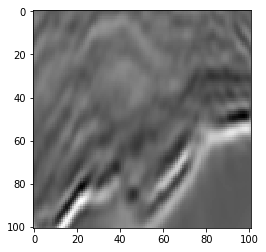

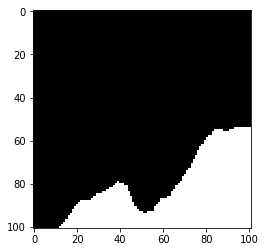

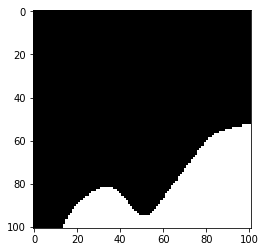

In [23]:
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [24]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}


A Jupyter Widget

In [25]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('outputs.csv')